In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import ccxt
import time

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [91]:
# Инициализация подключения к Coinbase
exchange = ccxt.coinbase({
    'enableRateLimit': True,  # Включение ограничения запросов
    'rateLimit': 300,        # Coinbase обычно имеет лимит 3 запроса в секунду
})

# Параметры запроса
symbol = 'BTC/USDT'
timeframe = '5m'
limit = 300  # Максимальное количество свечей за один запрос 
total_records = 601  # Общее количество записей, которые нужно получить

def fetch_ohlcv_with_pagination(symbol, timeframe, since, limit, total_records):
    """
    Функция для получения OHLCV данных с пагинацией
    """
    all_ohlcv = []
    remaining_records = total_records
    
    while remaining_records > 0:
        try:
            # Определяем сколько записей запросить в этом цикле (не больше лимита)
            current_limit = min(limit, remaining_records)
            
            # Делаем запрос
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, current_limit)
            
            if not ohlcv:
                break  # Если данные закончились
            
            # Добавляем полученные данные
            all_ohlcv.extend(ohlcv)
            
            # Уменьшаем количество оставшихся записей
            remaining_records -= len(ohlcv)
            
            # Обновляем since для следующего запроса (взять timestamp последней свечи + 5 минут)
            since = ohlcv[-1][0] + exchange.parse_timeframe(timeframe) * 1000
            
            # Пауза для соблюдения rate limit
            time.sleep(exchange.rateLimit / 1000)
            
        except Exception as e:
            print(f"Ошибка: {e}")
            time.sleep(5)  
    
    return all_ohlcv

# Вычисляем начальное время (since) - текущее время минус N свечей
now = exchange.milliseconds()
timeframe_seconds = exchange.parse_timeframe(timeframe) * 1000
since = now - (total_records * timeframe_seconds)

# Получаем данные
print(f"Начинаем загрузку {total_records} записей {symbol} с интервалом {timeframe}...")
ohlcv_data = fetch_ohlcv_with_pagination(symbol, timeframe, since, limit, total_records)

# Конвертируем в DataFrame
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']


Начинаем загрузку 601 записей BTC/USDT с интервалом 5m...
Ошибка: coinbase {"error":"INVALID_ARGUMENT","error_details":"start must not be in the future","message":"start must not be in the future"}
Ошибка: coinbase {"error":"INVALID_ARGUMENT","error_details":"start must not be in the future","message":"start must not be in the future"}
Ошибка: coinbase {"error":"INVALID_ARGUMENT","error_details":"start must not be in the future","message":"start must not be in the future"}


KeyboardInterrupt: 

In [49]:
df = pd.DataFrame(ohlcv_data, columns=columns)

# Преобразуем timestamp в  формат с таймзоной
df['time'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize('UTC')

df

,timestamp,open,high,low,close,volume,time
0,1746820500000,103200.11,103221.16,103111.31,103200.12,0.790869,2025-05-09 19:55:00+00:00
1,1746820800000,103206.28,103282.00,103206.28,103282.00,0.167461,2025-05-09 20:00:00+00:00
2,1746821100000,103267.76,103359.95,103267.76,103359.94,0.122954,2025-05-09 20:05:00+00:00
3,1746821400000,103403.00,103413.62,103318.56,103321.93,0.296948,2025-05-09 20:10:00+00:00
4,1746821700000,103326.44,103367.22,103326.44,103354.19,0.431346,2025-05-09 20:15:00+00:00
...,...,...,...,...,...,...,...
259,1746908700000,103268.67,103268.67,103224.36,103224.36,0.013192,2025-05-10 20:25:00+00:00
260,1746909000000,103236.22,103236.22,103233.47,103236.21,0.045379,2025-05-10 20:30:00+00:00
261,1746909600000,103270.74,103302.39,103263.85,103302.39,0.013522,2025-05-10 20:40:00+00:00
262,1746909900000,103297.35,103297.85,103289.82,103297.51,0.010023,2025-05-10 20:45:00+00:00


## Генерация фичей

<Axes: >

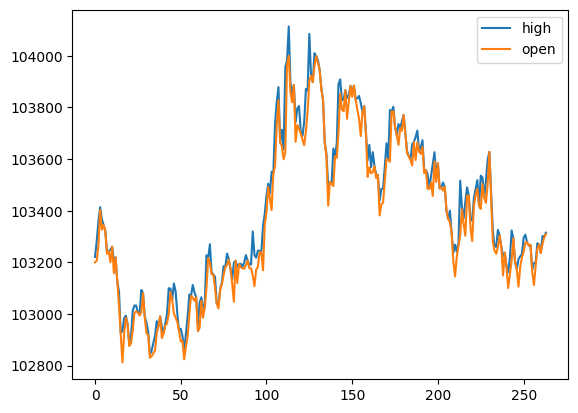

In [50]:
df[['high', 'open']].plot()

In [51]:
# Фичи сезонности

df['year']=df['time'].dt.strftime('%Y')
df['month']=df['time'].dt.strftime('%m')
df['day']=df['time'].dt.strftime('%d')
df['year_month']=df['time'].dt.strftime('%Y_%m')
df['hour']=df['time'].dt.strftime('%H')
df['minute']=df['time'].dt.strftime('%M')

## BaseLine

In [52]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
from matplotlib import  pyplot as plt

# Функция для добавления целевой переменной (таргета)
def add_target(df):
    df['close_next_hour'] = df['close'].shift(-12)
    df['target'] = (df['close_next_hour'] > df['close']).astype(int)
    df = df.dropna(subset=['close_next_hour'])
    
    return df

# Первый метод: фильтрация строк, где таргет не определён (например, NaN в close_next_hour)
def filter_invalid_targets(df):
    # Удаляем строки, где close_next_hour или target равен NaN
    return df.dropna(subset=['close_next_hour', 'target'])



## Трендовые фичи и тех. индикаторы

In [53]:
def create_trend_features(df, features, lag_periods):
    """
    Добавляет классические финансовые признаки: отношение к предыдущим периодам, логарифмические изменения и индикаторы трендов.
    
    df: DataFrame с исходными данными
    features: список признаков, для которых необходимо добавить индикаторы
    lag_periods: сколько периодов назад учитывать для расчетов
    
    Возвращает:
    - обновленный DataFrame с новыми фичами
    - список новых колонок, которые можно использовать как признаки
    """
    df = df.copy()  # Работаем с копией DataFrame
    new_columns = []  # Список для хранения новых колонок
    
    for feature in features:
        # Отношение текущего значения к предыдущему (лаг = 1)
        df[f'{feature}_ratio_1'] = df[feature] / df[feature].shift(1)
        new_columns.append(f'{feature}_ratio_1')
        
        # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
        df[f'{feature}_log_diff_1'] = np.log(df[feature] / df[feature].shift(1))
        new_columns.append(f'{feature}_log_diff_1')
        
        # Momentum (разница между текущим значением и значением N периодов назад)
        df[f'{feature}_momentum_{lag_periods}'] = df[feature] - df[feature].shift(lag_periods)
        new_columns.append(f'{feature}_momentum_{lag_periods}')
        
        # Rate of Change (ROC): процентное изменение за N периодов
        df[f'{feature}_roc_{lag_periods}'] = (df[feature] - df[feature].shift(lag_periods)) / df[feature].shift(lag_periods) * 100
        new_columns.append(f'{feature}_roc_{lag_periods}')
        
        # Exponential Moving Average (EMA) с периодом N
        df[f'{feature}_ema_{lag_periods}'] = df[feature].ewm(span=lag_periods, adjust=False).mean()
        new_columns.append(f'{feature}_ema_{lag_periods}')
    
    # Удаление строк с NaN значениями, которые появились из-за сдвигов
    df = df.dropna()
    
    return df, new_columns


In [54]:
def create_macd(df, feature, short_window=12, long_window=26):
    """
    Добавляет индикатор MACD (разница между краткосрочным и долгосрочным EMA).
    
    df: DataFrame с исходными данными
    feature: признак, для которого необходимо рассчитать MACD
    short_window: окно для краткосрочного EMA (по умолчанию 12)
    long_window: окно для долгосрочного EMA (по умолчанию 26)
    
    Возвращает:
    - обновленный DataFrame с MACD
    - название новой колонки с MACD
    """
    df = df.copy()
    
    # Рассчитываем краткосрочное и долгосрочное EMA
    ema_short = df[feature].ewm(span=short_window, adjust=False).mean()
    ema_long = df[feature].ewm(span=long_window, adjust=False).mean()
    
    # Разница между краткосрочным и долгосрочным EMA (MACD)
    df[f'{feature}_macd'] = ema_short - ema_long
    
    return df, f'{feature}_macd'

In [55]:
# Добавляем целевую переменную (таргет)
data = filter_invalid_targets(add_target(df))

# Параметры для создания трендовых признаков
lag_periods = 3  # Например, 3 периода назад
features_to_trend = ['open', 'high', 'low', 'close', 'volume']

# Создаем трендовые признаки
data_with_trend, new_trend_features = create_trend_features(data, features_to_trend, lag_periods)

# Добавляем MACD для признака 'close'
data_with_trend, macd_column = create_macd(data_with_trend, 'close')

# Добавляем название колонки с MACD в список новых фичей
new_trend_features.append(macd_column)

In [56]:
len(new_trend_features)

26

In [57]:
new_trend_features

['open_ratio_1',
 'open_log_diff_1',
 'open_momentum_3',
 'open_roc_3',
 'open_ema_3',
 'high_ratio_1',
 'high_log_diff_1',
 'high_momentum_3',
 'high_roc_3',
 'high_ema_3',
 'low_ratio_1',
 'low_log_diff_1',
 'low_momentum_3',
 'low_roc_3',
 'low_ema_3',
 'close_ratio_1',
 'close_log_diff_1',
 'close_momentum_3',
 'close_roc_3',
 'close_ema_3',
 'volume_ratio_1',
 'volume_log_diff_1',
 'volume_momentum_3',
 'volume_roc_3',
 'volume_ema_3',
 'close_macd']

In [58]:
data = data_with_trend[new_trend_features + ['target', 'time']]
data

,open_ratio_1,open_log_diff_1,open_momentum_3,open_roc_3,open_ema_3,high_ratio_1,high_log_diff_1,high_momentum_3,high_roc_3,high_ema_3,...,close_roc_3,close_ema_3,volume_ratio_1,volume_log_diff_1,volume_momentum_3,volume_roc_3,volume_ema_3,close_macd,target,time
3,1.001310,0.001309,202.89,0.196599,103319.238750,1.000519,0.000519,192.46,0.186454,103359.692500,...,0.118033,103311.215000,2.415110,0.881745,-0.493920,-62.452879,0.299004,0.000000,0,2025-05-09 20:10:00+00:00
4,0.999260,-0.000741,120.16,0.116427,103322.839375,0.999551,-0.000449,85.22,0.082512,103363.456250,...,0.069896,103332.702500,1.452595,0.373352,0.263885,157.580390,0.365175,2.573447,0,2025-05-09 20:15:00+00:00
5,1.000174,0.000174,76.64,0.074215,103333.619688,0.999779,-0.000221,-15.55,-0.015045,103353.928125,...,-0.030873,103330.366250,0.252169,-1.377657,-0.014183,-11.534774,0.236973,2.473516,0,2025-05-09 20:20:00+00:00
6,0.999783,-0.000217,-80.99,-0.078325,103327.814844,0.999783,-0.000217,-91.61,-0.088586,103337.969062,...,-0.093059,103278.073125,7.648715,2.034538,0.535017,180.171595,0.534469,-5.789661,0,2025-05-09 20:30:00+00:00
7,0.999138,-0.000862,-93.45,-0.090442,103280.402422,0.999188,-0.000813,-129.15,-0.124943,103288.019531,...,-0.112352,103258.071563,0.041984,-3.170456,-0.396416,-91.902183,0.284699,-11.217282,0,2025-05-09 20:35:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.999349,-0.000651,-186.88,-0.180923,103151.120189,1.000387,0.000387,-79.83,-0.077285,103209.851191,...,-0.029593,103157.712223,2.189301,0.783582,0.109760,117.746064,0.138110,-62.486452,1,2025-05-10 19:15:00+00:00
248,1.000740,0.000739,-20.30,-0.019670,103166.660095,1.000100,0.000100,20.85,0.020203,103216.600596,...,0.034636,103190.531111,0.446183,-0.807027,0.086398,2073.494528,0.114338,-56.399416,1,2025-05-10 19:20:00+00:00
249,1.000361,0.000361,46.41,0.044983,103193.075047,1.000082,0.000082,58.78,0.056972,103224.230298,...,0.141241,103211.195556,0.954797,-0.046256,-0.006242,-6.732698,0.100405,-50.308782,1,2025-05-10 19:25:00+00:00
250,1.000203,0.000203,134.55,0.130497,103216.777524,1.000616,0.000616,82.50,0.079932,103259.855149,...,0.120162,103252.217778,0.548092,-0.601311,-0.155583,-76.650487,0.073899,-40.067188,1,2025-05-10 19:30:00+00:00


## Samples split

In [59]:
# Преобразуем столбец времени к формату datetime (если еще не сделано)
# data['time'] = pd.to_datetime(data['time'])

# Определяем дату начала тестовой выборки (последняя неделя)
test_start_date = data['time'].max() - pd.DateOffset(hours=2)

# Определяем дату начала валидационной выборки (предпоследний месяц)
val_start_date = data['time'].max() - pd.DateOffset(hours=4)

# Разделение данных на тренировочную, валидационную и тестовую выборки по времени
train_data = data[data['time'] < val_start_date]  # все, что до предпоследнего месяца
val_data = data[(data['time'] >= val_start_date) & (data['time'] < test_start_date)]  # предпоследний месяц
test_data = data[data['time'] >= test_start_date]  # последний месяц

# Признаки, которые будем использовать
features = new_trend_features  # Убедись, что 'new_trend_features' определены

# Разделение на признаки (X) и целевую переменную (y) для каждой выборки
X_train = train_data[new_trend_features]
y_train = train_data['target']

X_val = val_data[new_trend_features]
y_val = val_data['target']

X_test = test_data[new_trend_features]
y_test = test_data['target']

# Проверим размерности, если нужно
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 202, Val size: 24, Test size: 23


## MODELS

In [60]:
from IPython.display import display, Markdown

In [61]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score


def calculate_metrics_table(y_true, y_pred_prob, thresholds=[0.5, 0.6, 0.7, 0.8]):
    metrics_table = []
    
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        metrics = {
            'Cutoff': threshold,
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1-Score': f1_score(y_true, y_pred)
        }
        metrics_table.append(metrics)
    
    # Преобразуем список словарей в DataFrame для удобного вывода
    return pd.DataFrame(metrics_table)*100

In [62]:
# Выводим ROC AUC и метрики для всех выборок
def display_metrics_set(name, y_true, y_pred_prob):
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    print(f"\n=== Метрики для {name} выборки ===")
    print(f"ROC AUC: {roc_auc:.4f}")
    metrics_table = calculate_metrics_table(y_true, y_pred_prob)
    print(metrics_table)


### Decision Tree

In [63]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# 1. Обучение модели решающего дерева на тренировочной выборке
model = DecisionTreeClassifier(max_depth=4)  # Используем случайное состояние для повторимости

model = DecisionTreeClassifier(
    max_depth=4,               # Ограничивает глубину дерева. Меньшая глубина снижает вероятность переобучения.
    min_samples_split=10,      # Минимальное число образцов, необходимых для разделения узла. Большее значение предотвращает разделение узлов с малым числом выборок.
    min_samples_leaf=5,        # Минимальное число образцов, которое должно быть в каждом листовом узле. Более высокое значение делает дерево более стабильным.
    max_leaf_nodes=15,         # Ограничивает максимальное число листовых узлов. Чем меньше листьев, тем проще модель.
#     min_impurity_decrease=0.01,# Минимальное уменьшение нечистоты, требуемое для разделения узла. Чем больше значение, тем сложнее узел разделить.
    random_state=42,           # Устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость результатов.
#     ccp_alpha=0.01             # Параметр обрезки сложностей, контролирующий обрезку узлов. Чем больше значение, тем больше узлов удаляется для упрощения дерева.
)

model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=15, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [64]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [65]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.9158


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,95.890411,69.306931,83.168317,80.459770
1,60.0,95.890411,69.306931,83.168317,80.459770
2,70.0,98.529412,66.336634,82.673267,79.289941
3,80.0,98.529412,66.336634,82.673267,79.289941


In [66]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.3636


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,0.0,0.0,33.333333,0.0
1,60.0,0.0,0.0,33.333333,0.0
2,70.0,0.0,0.0,33.333333,0.0
3,80.0,0.0,0.0,33.333333,0.0


In [67]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.3269


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,28.571429,15.384615,30.434783,20.0
1,60.0,28.571429,15.384615,30.434783,20.0
2,70.0,28.571429,15.384615,30.434783,20.0
3,80.0,28.571429,15.384615,30.434783,20.0


### RandomForestClassifier

In [68]:
from sklearn.ensemble import RandomForestClassifier

# 1. Обучение модели случайного леса на тренировочной выборке
model = RandomForestClassifier(
    n_estimators=100,            # Количество деревьев в лесу. Большее количество деревьев может улучшить точность, но увеличивает время обучения.
    max_depth=5,                 # Максимальная глубина каждого дерева. Ограничение глубины снижает вероятность переобучения.
    min_samples_split=10,        # Минимальное число образцов для разделения узла. Большее значение предотвращает разделение узлов с малым числом выборок.
    min_samples_leaf=5,          # Минимальное количество выборок, которое должно находиться в каждом листе. Увеличение значения делает модель более устойчивой.
#     max_features='sqrt',         # Максимальное количество признаков, используемых при поиске лучшего разбиения. "sqrt" берёт корень из общего числа признаков.
#     max_leaf_nodes=20,           # Максимальное число листьев в каждом дереве. Ограничивает количество конечных узлов, упрощая структуру дерева.
#     min_impurity_decrease=0.01,  # Минимальное уменьшение нечистоты, требуемое для разделения. Предотвращает создание слишком мелких узлов.
#     bootstrap=True,              # Использовать бутстрэп (выборка с возвращением) для создания деревьев. Это повышает устойчивость модели.
    random_state=42              # Устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость результатов.
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [69]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [70]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.9685


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,87.850467,93.069307,90.099010,90.384615
1,60.0,93.181818,81.188119,87.623762,86.772487
2,70.0,100.000000,60.396040,80.198020,75.308642
3,80.0,100.000000,28.712871,64.356436,44.615385


In [71]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.4196


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,54.545455,92.307692,54.166667,68.571429
1,60.0,30.000000,23.076923,29.166667,26.086957
2,70.0,100.000000,23.076923,58.333333,37.500000
3,80.0,0.000000,0.000000,45.833333,0.000000


In [72]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.3769


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,52.631579,76.923077,47.826087,62.500000
1,60.0,33.333333,15.384615,34.782609,21.052632
2,70.0,33.333333,7.692308,39.130435,12.500000
3,80.0,0.000000,0.000000,34.782609,0.000000


### XGBoost

In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

model = XGBClassifier(
    objective='binary:logistic',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_seed=42,
)

# Добавляем валидационную выборку как eval_set и используем early_stopping
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_seed=42, ...)

In [74]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [75]:
print("\n=== Метрики для тренировочной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для тренировочной выборки ===
ROC AUC: 1.0000


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,99.019608,100.000000,99.504950,99.507389
1,60.0,100.000000,100.000000,100.000000,100.000000
2,70.0,100.000000,95.049505,97.524752,97.461929
3,80.0,100.000000,81.188119,90.594059,89.617486


In [76]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.4196


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,60.000000,46.153846,54.166667,52.173913
1,60.0,50.000000,30.769231,45.833333,38.095238
2,70.0,40.000000,15.384615,41.666667,22.222222
3,80.0,33.333333,7.692308,41.666667,12.500000


In [77]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.3615


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,50.000000,38.461538,43.478261,43.478261
1,60.0,16.666667,7.692308,26.086957,10.526316
2,70.0,20.000000,7.692308,30.434783,11.111111
3,80.0,33.333333,7.692308,39.130435,12.500000


### Optuna

In [78]:
import optuna
from sklearn.metrics import roc_auc_score


def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # мониторинг AUC в логе
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'tree_method': 'hist',  # для скорости
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': 100,
        'random_seed': 42,
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc 

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2, n_jobs=-1)  # 50 итераций оптимизации

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший ROC AUC Score:", best_score)

[I 2025-05-10 23:57:08,217] A new study created in memory with name: no-name-1b94a9aa-38f7-4d32-834d-cbd5ba934f3c
[23:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

[23:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

[I 2025-05-10 23:57:08,481] Trial 0 finished with value: 0.44755244755244755 and parameters: {'eta': 0.10090783923309703, 'max_depth': 4, 'lambda': 2.1334168888465946e-06, 'alpha': 1.4989840535579788e-07, 'gamma': 0.8755108456366291, 'min_child_weight': 10, 'subsample': 0.6661977011889956, 'colsample_bytree': 0.8292612460742099}. Best is trial 0 with value: 0.44755244755244755.
[I 2025-05-10 23:57:08,515] Trial 1 finished with value: 0.46153846153846156 and parameters: {'eta': 0.2605871670802935, 'max_depth': 8, 'lambda': 9.528155182679545e-06, 'alpha': 0.0007320596633664488, 'gamma': 0.5347794553499874, 'min_child_weight': 1, 'subsampl

Лучшие параметры: {'eta': 0.2605871670802935, 'max_depth': 8, 'lambda': 9.528155182679545e-06, 'alpha': 0.0007320596633664488, 'gamma': 0.5347794553499874, 'min_child_weight': 1, 'subsample': 0.8325108748292576, 'colsample_bytree': 0.9034534118994828}
Лучший ROC AUC Score: 0.46153846153846156


In [79]:
# Инициализация модели XGBClassifier с оптимальными гиперпараметрами
optimal_params = study.best_params
model = XGBClassifier(
    **optimal_params,
    random_seed=42,
    n_estimators=100,
    verbose=0
)

# Обучение модели на тренировочной выборке с валидационной проверкой для контроля
model.fit(X_train, y_train, verbose=0)

XGBClassifier(alpha=0.0007320596633664488, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9034534118994828, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.2605871670802935, eval_metric=None, feature_types=None,
              gamma=0.5347794553499874, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=9.528155182679545e-06,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100, ...)

In [80]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [81]:
print("\n=== Метрики для тренировочной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для тренировочной выборки ===
ROC AUC: 1.0000


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,100.0,100.000000,100.00000,100.000000
1,60.0,100.0,100.000000,100.00000,100.000000
2,70.0,100.0,100.000000,100.00000,100.000000
3,80.0,100.0,99.009901,99.50495,99.502488


In [82]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.4615


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,54.545455,46.153846,50.000000,50.000000
1,60.0,50.000000,38.461538,45.833333,43.478261
2,70.0,50.000000,23.076923,45.833333,31.578947
3,80.0,50.000000,23.076923,45.833333,31.578947


In [83]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.3615


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,37.500000,23.076923,34.782609,28.571429
1,60.0,42.857143,23.076923,39.130435,30.000000
2,70.0,33.333333,15.384615,34.782609,21.052632
3,80.0,33.333333,15.384615,34.782609,21.052632
